# <center> ALZHEİMER HASTALIĞI TESPİTİ</center>
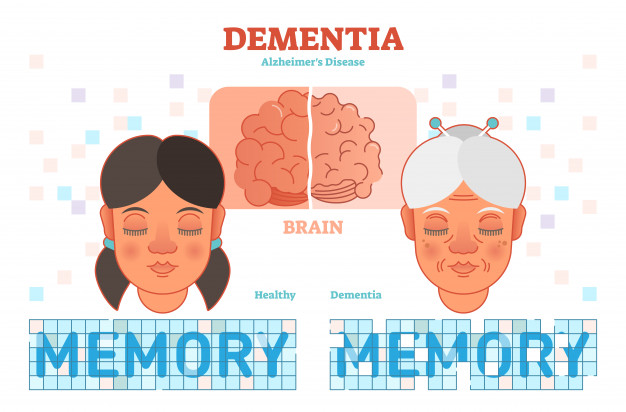
<h1><center> Alperen Toraman 21827919</center><center>  Oğuzhan Dursun 21727187</center></h1>

Bu projede özellikle ileri yaşlarda ortaya çıkan ve hayat kalitesini yüksek miktarda düşüren bir rahatsızlık olan Alzheimer'ın çeşitli safhalarını manyetik rezonans görüntüleri üzerinden , farklı sınıflandırma metodları ile tespitinin yapılması amaçlanmıştır. Bu amaç doğrultusunda KNN, Random Forest Classification, SVM, DenseNet ve VGG16 metodları kullanılmıştır. Bu algoritmaların sonuçlarının karşılaştırılması sonucunda %86.91 oranıyla en başarılı algoritma DenseNet algoritması olmuştur.


## İçerik

[Problem](#problem)   
[Verinin Anlaşılması](#data_understanding)   
[Verilerin Hazırlanması](#data_preparation)   
[Modelleme](#modeling)   
[Değerlendirme](#evaluation)   
[Referanslar](#references)   

## Problem <a class="anchor" id="problem"></a>

Alzheimer, yaygın görülen bir demans türü olup beyin hücrelerinin yok olmasına neden olan ilerleyici bir nörolojik hastalıktır. Düşünce, hafıza ve davranış fonksiyonlarında azalmaya neden olan bu hastalıkta belirtiler yaşla birlikte yavaş yavaş ortaya çıkar. Alzheimer kesin bir tedavisi olmayan bir hastalıktır ancak erken tanı ile hastalığın ilerleyişi ve hastanın hayat kalitesindeki düşüş yavaşlatılabilir. Alzheimer'ın başlangıç safhalarındaki belirtiler ciddiye alınmayabilir ve yaşlılık nedeniyle olduğu düşünülebilir. Bu proje ile herhangi şüpheye sahip potansiyel hastanın durumu hakkında hızlı ve kolay bir şekilde ön tanı konulabilir.  

Veri setimiz Alzheimer hastalarının beyinlerinin manyetik rezonans görüntülerini içermektedir, bu görüntüler eğitim ve test için ayrı şekilde klasörlenmiştir. Görüntüler Alzheimer'ın dört farklı evresinden oluşmaktadır. Bu evreler:
* Orta Demanslı
* Hafif Demanslı
* Çok Hafif Demanslı
* Demanssız 

şeklindedir.

### Projede kullanılacak kütüphaneler

Bu projede Pandas, Numpy gibi temel kütüphanelerin yanında görselleştirme için Matplotlib-Seaborn, çeşitli ML algoritmalarını sağlayan Scikit-learn, görüntü işleme için OpenCV ve derin öğrenme işlemlerinde kullanılan Tensorflow kütüphanelerini kullandık.

In [2]:
from collections import Counter
import cv2
import glob
import skimage.transform
import numpy as np
import pandas as pd
import seaborn as sn
import preprocessing
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler,LabelBinarizer,LabelEncoder
from sklearn.neighbors import KNeighborsClassifier # KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb 
from keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16

## Verinin Anlaşılması<a class="anchor" id="data_understanding"></a>

MR görüntülerinden oluşan veri setimizi inceleyerek verilerimizi açıklayıcı ve görsel bir şekilde sunmaya çalıştık. Verilerin dağılımını gösteren histogramlar, dairesel grafikler ve tablolardan yararlandık. Farklı evrelerden bazı görüntüleri de göstererek veri seti görüntüleri hakkında fikir edindik.  Bunlarla beraber veri setimiz hakkında daha detaylı yorum yapabileceğiz. 6400 görüntüden(176x208 piksel) oluşan veri setinde 5121 eğitim, 1279 test verisi bulunmaktadır. Her görüntü 4 Alzheimer seviyesinden biriyle ilişkilidir. Bu da bizim çok sınıflı sınıflandırma yapacağımızı gösterir.

In [2]:
def loadImages(path):
    sample = []
    
    for filename in glob.glob(path):
        
        img = cv2.imread(filename)
        img = skimage.transform.resize(img, (224, 224, 3))
        IMG = np.array(img)
        sample.append(IMG) 
    return sample

OpenCV’nin imread ve resize fonksiyonlarını kullanarak resimleri yükleyip aynı formata getirdik. Aynı zamanda resize fonksiyonu ile resimlerin boyutlarını küçülttük, bu yapmamızın bir başka nedeni ise GPU üzerinden çalıştırdığımız algoritmaların batch boyutuna daha yüksek bir değer atayabilmektir.

In [3]:
train_ND = loadImages('./Alzheimer_s Dataset/train/NonDemented/*.jpg')
train_VMD = loadImages('./Alzheimer_s Dataset/train/VeryMildDemented/*.jpg')
train_MID = loadImages('./Alzheimer_s Dataset/train/MildDemented/*.jpg')
train_MOD = loadImages('./Alzheimer_s Dataset/train/ModerateDemented/*.jpg')

test_ND = loadImages('./Alzheimer_s Dataset/test/NonDemented/*.jpg' )
test_VMD = loadImages('./Alzheimer_s Dataset/test/VeryMildDemented/*.jpg')
test_MID = loadImages('./Alzheimer_s Dataset/test/MildDemented/*.jpg')
test_MOD = loadImages('./Alzheimer_s Dataset/test/ModerateDemented/*.jpg')


In [4]:
df_train_ND = pd.DataFrame({'image':train_ND, 'label': 'ND'})
df_train_VMD = pd.DataFrame({'image':train_VMD, 'label': 'VMD'})
df_train_MID = pd.DataFrame({'image':train_MID, 'label': 'MID'})
df_train_MOD = pd.DataFrame({'image':train_MOD, 'label': 'MOD'})

df_test_ND = pd.DataFrame({'image':test_ND, 'label': 'ND'})
df_test_VMD = pd.DataFrame({'image':test_VMD, 'label': 'VMD'})
df_test_MID = pd.DataFrame({'image':test_MID, 'label': 'MID'})
df_test_MOD = pd.DataFrame({'image':test_MOD, 'label': 'MOD'})

In [5]:
train_counts = [df_train_ND.shape[0],df_train_VMD.shape[0],df_train_MID.shape[0],df_train_MOD.shape[0]]
test_counts = [df_test_ND.shape[0],df_test_VMD.shape[0],df_test_MID.shape[0],df_test_MOD.shape[0]]

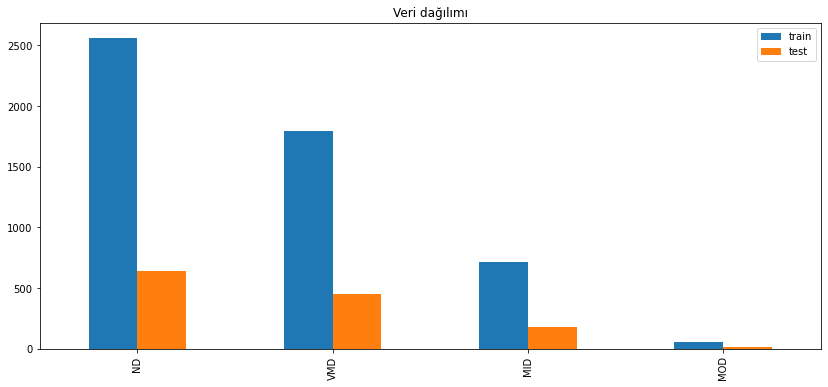

In [7]:
class_names = ["ND","VMD","MID","MOD"]
pd.DataFrame({'train': train_counts, 'test':test_counts}, 
             index=class_names
            ).plot.bar(figsize=(14,6))
plt.title("Veri dağılımı")
plt.show()

Veri setimiz toplam 6400 adet görüntüden oluşmaktadır. Eğitim ve test dataları görüldüğü üzere yaklaşık 80:20 oranında dağılmıştır. Histogramdan da görebildiğimiz üzere hastalık seviyesi ilerledikçe veri sayımızda bir azalma olmuştur.

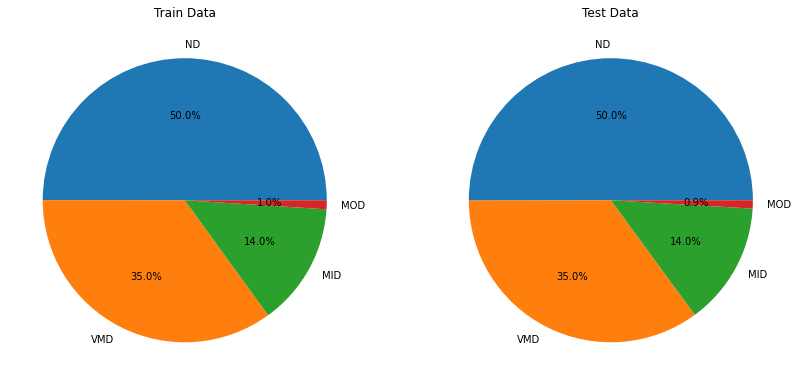

,ND,VMD,MID,MOD
Train,2560,1792,717,52
Test,640,448,179,12
Total,3200,2240,896,64


In [8]:
fig, ax=plt.subplots(1,2,figsize=(14, 7))
ax[0].pie(train_counts,
        labels=class_names,
        autopct='%1.1f%%')
ax[0].set_title("Train Data")
ax[1].pie(test_counts,
        labels=class_names,
        autopct='%1.1f%%')
ax[1].set_title("Test Data")

plt.show()
data = [train_counts,
        test_counts,
        np.array(train_counts)+np.array(test_counts)]
indexes = ["Train","Test","Total"]
display(pd.DataFrame(data,columns=["ND","VMD","MID","MOD"],index=indexes))

Veri setimizin yarısını demanssız bireylerin MR görüntüleri, hemen ardından %35 ile çok hafif demanslı bireylerin MR görüntüleri yer alırken %14 oranında hafif demanslı bireylerin MR görüntüleri kalanı ise orta demanslı bireylerin MR görüntülerinden oluşmaktadır. Bu oranlar eğitim ve test seti için aynıdır. Sayısal olarak bakacak olursak toplamda 3200 adet demanssız, 2240 adet çok hafif demanslı, 896 adet hafif demanslı, 64 adet ise orta demanslı bireyin MR görüntüsü bulunmaktadır.

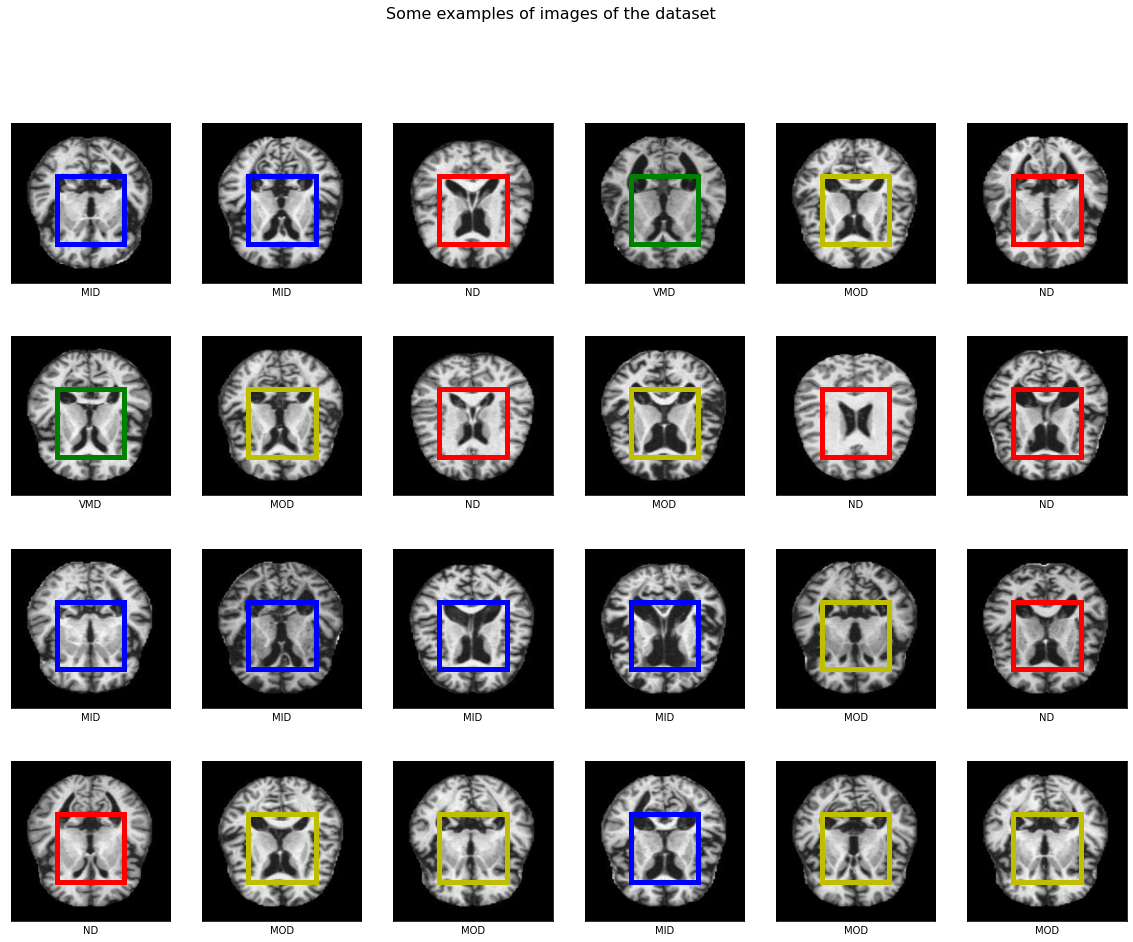

In [9]:
import random
import matplotlib.patches as patches
def display_examples(train,color):
    fig = plt.figure(figsize=(20,15))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(24):
        number = random.randint(0,3)
        data = train[number]
        ax = plt.subplot(4,6,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        index = random.randint(0,len(data)-1)
        
        plt.imshow(data.image[index], cmap=plt.cm.binary)
        box = patches.Rectangle((64,74), 95, 95, linewidth=5, edgecolor=color[number], facecolor='none')
        ax.add_patch(box)
        plt.xlabel(data.label[index])
    plt.show()
display_examples([df_train_ND,df_train_VMD,df_train_MID,df_train_MOD],["r","g","b","y"])

Burada farklı sınıflara ait MR görüntülerinden rastgele örnekler seçilmiştir ve sınıflarına renklendirme yapılmıştır. Görüntüler arasında farklı sınıflardan birbirlerine benzeyen görüntüler olduğu gibi aynı sınıftan farklılıklar içeren görüntülerinde mevcut olduğu görülmektedir. Bu durum Alzheimer'ın evrelerinin ayırt edilmesinin zorluğunu göstermektedir aynı zamanda oluşturduğumuz sınıflandırma modellerinden birçoğunun tespit doğruluğunun yeteri kadar başarı gösterememesinin bir sebebi de bu olabilir. Buna rağmen CNN metodlarımız tespit doğruluğunda daha başarılı sonuçlar vermiştir.

## Verilerin Hazırlanması <a class="anchor" id="data_preparation"></a>

Görüntü işlemeyi kolaylaştırmak için verilerimizi çeşitli formatlara dönüştürmemiz gerekmektedir. KNN, SVM, Random Forest gibi algoritmalar için etiketlerine göre ayırdığımız farklı demans türlerini tek bir dataframe altında topladık. Verilerimizi bir araya topladıktan sonra kategorik değişken olan sınıf isimlerini işleyebilmek için onları LabelEncoder yardımıyla sayısal değerlere dönüştürdük.

In [10]:
final_data = [df_train_ND, df_train_VMD, df_train_MID, df_train_MOD, df_test_ND, df_test_VMD, df_test_MID, df_test_MOD]
final_data = pd.concat(final_data)

In [11]:
train_data = final_data['image']
labels = final_data['label']

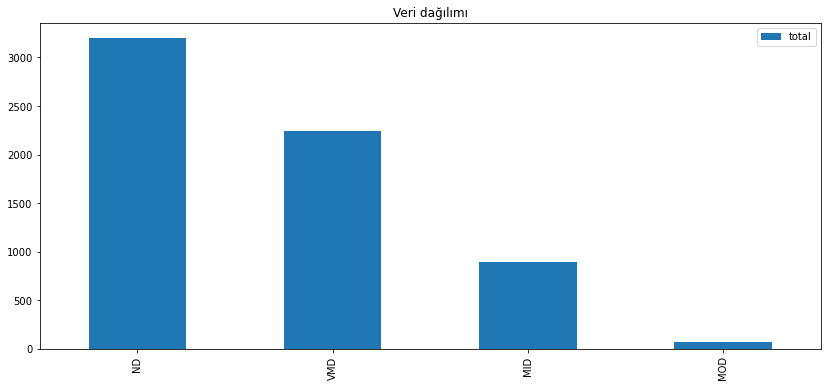

Counter({'ND': 3200, 'VMD': 2240, 'MID': 896, 'MOD': 64})

In [15]:
pd.DataFrame({'total': Counter(np.array(labels))}, 
             index=class_names
            ).plot.bar(figsize=(14,6))
plt.title("Veri dağılımı")
plt.show()
Counter(np.array(labels))

In [16]:
onehot = LabelEncoder()
labels = onehot.fit_transform(labels)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(train_data, labels,
                                                  test_size = 0.2,
                                                  stratify = labels,
                                                  shuffle = True,
                                                  random_state = 42)

In [18]:
def convertToTensor(data):
    data = np.array(data)
    converted= np.empty((len(data),data[0].shape[0],data[0].shape[1],data[0].shape[2]))
    for i in range(0, len(data)):
        converted[i] = data[i]
    return converted

In [19]:
X_train = convertToTensor(X_train)
X_test = convertToTensor(X_test)

KNN, SVM ve Random Forest algoritmalarında kullanmak için pandas dataframe de tuttuğumuz verilerimizi algoritmalarda istenen Tensor formatına dönüştürdük.

In [20]:
base_model = NASNetMobile(include_top=False, weights='imagenet', input_shape=(224,224,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='tanh')(x)

predictions = Dense(4, activation='tanh')(x)

model_feat = Model(inputs=base_model.input,outputs=predictions)

train_features = model_feat.predict(X_train)
test_features=model_feat.predict(X_test)

NasNetMobile, Keras'ın bizlere sunduğu görselleri sınıflandırmada ve pooling aracılığıyla boyutlarını istenen formata getirmede kullanılan bir sınıftır. Burada 4D Tensor'u 2D Tensor'e dönüştürmede kullanılmıştır. Bu model KNN, SVM ve Random Forest Classifier için kullanılacaktır.

In [21]:
X_test,y_test=test_features,y_test

Yukarıda gerçekleştirdiğimiz veri hazırlıkları belirttiğimiz gibi KNN, SVM ve Random Forest algoritmaları içindi ancak CNN algoritmaları olan VGG ve DenseNet için farklı bir veri hazırlığı aracı olan ImageDataGenerator'ı kullanmayı tercih ettik.

ImageDataGenerator, Keras'ın görüntü verilerini düzenleyip, veri işleme ile CNN metodlarında kullanıma uygun hale getirilmesi için kullandığı bir sınıftır. Verilerimiz zaten sınıflarına göre klasörlere ayrılmış oldukları için , flow_from_directory metodu bu verileri okuyup sınıflandırma açısından en uygun metodtur.

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [7]:
train_dataset  = train_datagen.flow_from_directory(directory = './DSCP/Alzheimer_s Dataset/train',
                                                   target_size = (176,176),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 4)

Found 5121 images belonging to 4 classes.


In [8]:
test_dataset = test_datagen.flow_from_directory(directory = './DSCP/Alzheimer_s Dataset/test',
                                                  target_size = (176,176),
                                                  class_mode = 'categorical',
                                                  batch_size = 4)

Found 1279 images belonging to 4 classes.


## Modelleme <a class="anchor" id="modeling"></a>

Bu projedeki algoritmalar denetimli öğrenme algoritmalarıdır. Denetimli öğrenme algoritmalarında veri kümemizi ve bu verilerden istenen sonucun ne olduğu bilinmelidir. Denetimli öğrenme regresyon ve sınıflandırma olarak ikiye ayrılır, biz bu projede sınıflandırma algoritmalarını kullanacağız.

Sınıflandırma algoritmaları, eğitim setindeki verileri hangi sınıfa atayacağını öğrenir.  Daha sonra test setindeki verileri doğru sınıflara atamaya çalışır. Bu işlemlerden sonra modelimizin verinin sınıfını tespit etmedeki başarısı ölçülür.

## KNN

k-en yakın komşuluk (KNN) algoritması gözetimli öğrenme algoritmalarından biridir. Sınıflandırma problemlerinde kullanılır ve uygulaması kolay olduğu için de çok kullanılan bir algoritmadır. Aslında tam olarak eğitim verilerini öğrenme üzerine çalışan bir algoritma değildir, tembel bir öğrenme türü olarak nitelendirilir. Çünkü eğitim ve test neredeyse aynı şey gibidir. Büyük veri setlerinde uygun bir algoritma olarak görülmez çünkü tüm durumları bellekte sakladığından çok fazla bellek alanına ihtiyaç duyar. 

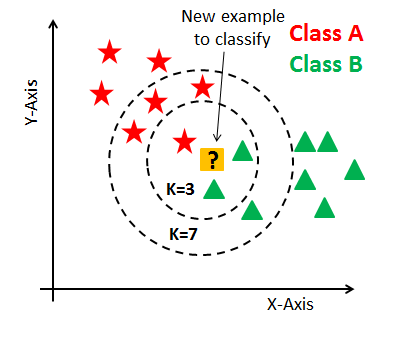

Tahmin yaparken de tüm veri setinde en yakın komşularla ilgilenir. Burada K değeri bakılacak komşu sayısını temsil eder.  Genelde tek sayı tercih edilir. Projemizde bu sayıyı belirlerken ilk 17 K değeri için doğruluk değeri hesaplanarak en iyi K değerini seçtik. Daha sonra ise scikit-learn kütüphanesi neighbors modülü KNeighborClassifier sınıfı ile modelimizi oluşturduk.

In [23]:
max_neigbors_count=17
accuracies=[]
for i in range(1,max_neigbors_count+1):
    model = KNeighborsClassifier(n_neighbors=i,n_jobs=-1)
    model.fit(train_features,y_train)
    accuracies.append(model.score(X_test, y_test)*100)
    print(str(i)+"-NN accuracy: {:.2f}%".format(accuracies[-1]))


1-NN accuracy: 42.81%
2-NN accuracy: 42.34%
3-NN accuracy: 41.25%
4-NN accuracy: 45.00%
5-NN accuracy: 44.45%
6-NN accuracy: 47.19%
7-NN accuracy: 47.42%
8-NN accuracy: 47.89%
9-NN accuracy: 49.38%
10-NN accuracy: 49.30%
11-NN accuracy: 48.83%
12-NN accuracy: 49.84%
13-NN accuracy: 48.44%
14-NN accuracy: 49.53%
15-NN accuracy: 49.92%
16-NN accuracy: 49.61%
17-NN accuracy: 49.45%


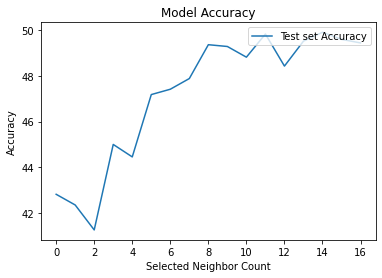

In [24]:
plt.plot(accuracies)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Selected Neighbor Count')
plt.legend(['Test set Accuracy'], loc='upper right')
plt.show()

In [25]:
model=KNeighborsClassifier(n_neighbors=15)
model.fit(train_features,y_train)
y_pred_test=model.predict(X_test)
accuracies = []
accuracies.append(model.score(X_test, y_test)*100)
print("17-NN accuracy: ",model.score(X_test, y_test)*100)

17-NN accuracy:  49.921875


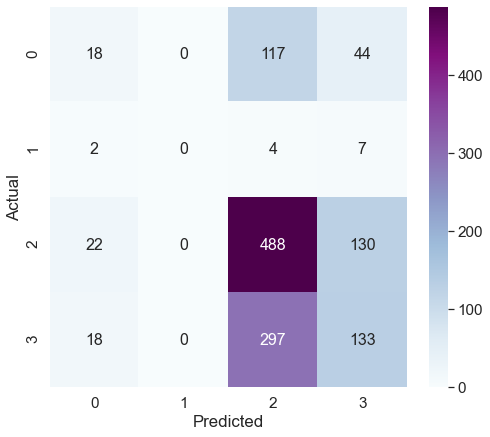

In [26]:
conf_mx = confusion_matrix(y_test, y_pred_test)
heat_cm = pd.DataFrame(conf_mx, columns=np.unique(y_test), index = np.unique(y_test))
heat_cm.index.name = 'Actual'
heat_cm.columns.name = 'Predicted'
plt.figure(figsize = (8,7))
sn.set(font_scale=1.4) # For label size
sn.heatmap(heat_cm, cmap="BuPu", annot=True, annot_kws={"size": 16},fmt='g')# font size
plt.show()

# Random Forest

Random Forest hem sınıflandırma hem de regresyon algoritmalarında kullanılabilmektedir. Biz amacımız ve veri setimiz doğrultusunda Random Forest'i sınıflandırma algoritması için kullanacağız . Random Forest sınıflandırmasının çalışma prensibi ise sınıflandırma işleminde bir çok ağaç yapısı oluşturup sınıflandırma değerini yükseltmektir. Bu ağaç yapıları veri setindeki verilerin alt kümelerinden oluşur.

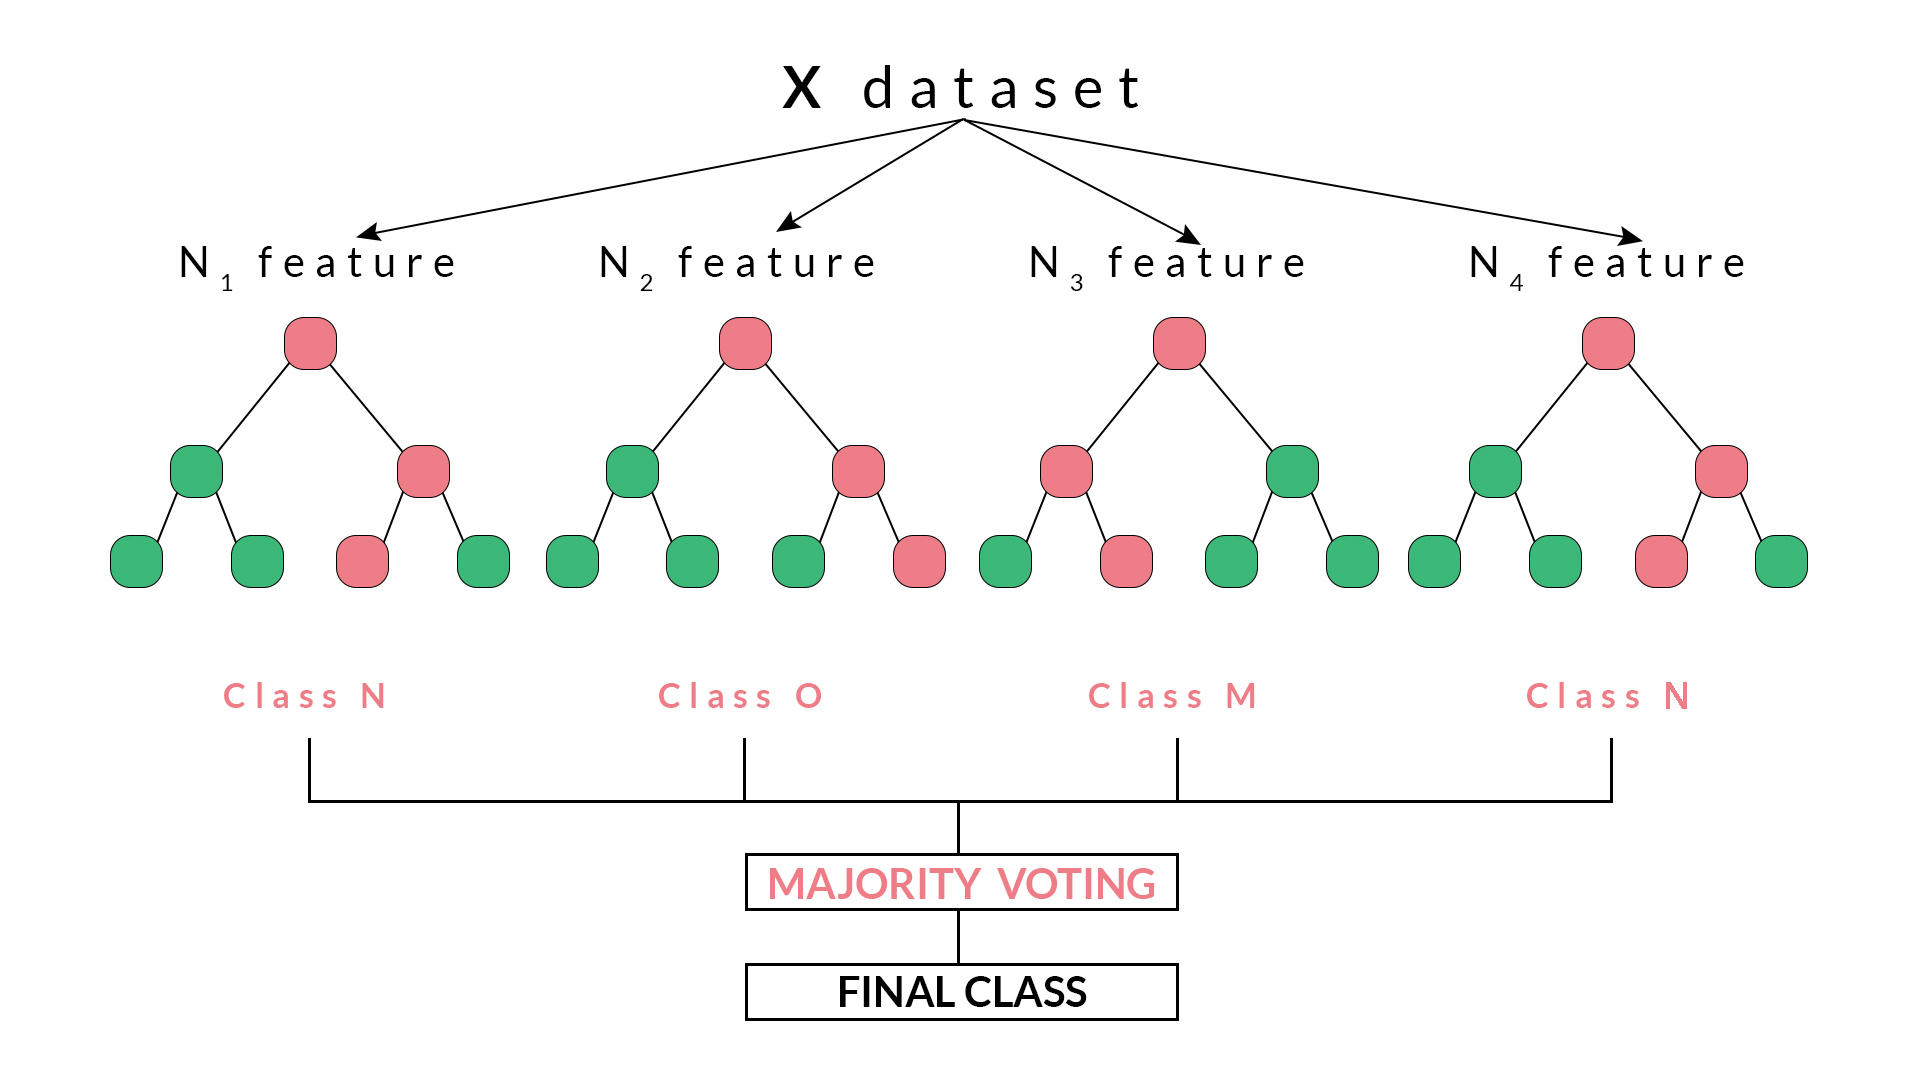

Biz RandomForestClassifier kullandığımız için default ağaç sayısı bu class için 100 dür. Bu ağaçlara karar ağacı da denmektedir.Bu ağaçların toplulukları 'Forest' yani ormanımızı oluşturur. Bu orman yapısı overfitting azaltırken bir yandan da daha doğru sonuçlar almamızı sağlar. Bizim kullandığımız sınıflandırma için oluşturulan bir orman olduğundan dolayı bu ağaçlar arasında en iyi sınıflandırmayı yapabilen ağaç seçilmektedir, regresyon için kullanımında ise farklı ağaçların ortalamaları kullanılır.


In [27]:
from sklearn.svm import SVC
model=RandomForestClassifier()
model.fit(train_features,y_train)
y_pred_test=model.predict(X_test)
accuracies.append(model.score(X_test, y_test)*100)
print("Random Forest: ",accuracies[1])

Random Forest:  49.140625


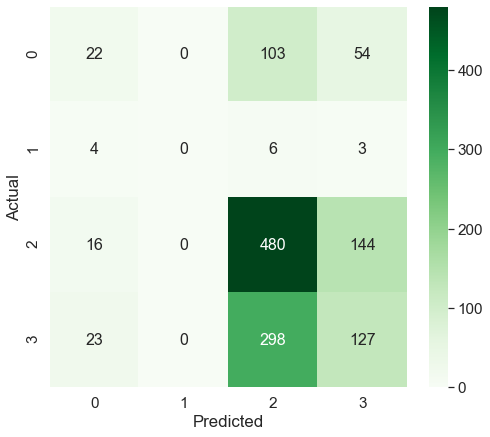

In [28]:
conf_mx = confusion_matrix(y_test, y_pred_test)
heat_cm = pd.DataFrame(conf_mx, columns=np.unique(y_test), index = np.unique(y_test))
heat_cm.index.name = 'Actual'
heat_cm.columns.name = 'Predicted'
plt.figure(figsize = (8,7))
sn.set(font_scale=1.4) # For label size
sn.heatmap(heat_cm, cmap="Greens", annot=True, annot_kws={"size": 16},fmt='d')# font size
plt.show()

## SVM

Destek vektör makine algoritması gözetimli öğrenme algoritmalarından biridir. Hem sınıflandırma hem regresyon problemlerinde kullanılabilmektedir, ancak bizimde tercih edeceğimiz sınıflandırma için kullanımı daha yaygındır. 

SVM algoritmasının prensibi düzlem üzerindeki noktaların bir doğru veya hiper düzlem ile ayrıştırılması ve sınıflandırılmasıdır. Küçük ve orta büyüklükteki veri setleri için daha uygundur. Scale işlemine duyarlıdır, scale edilmesi gerekir.

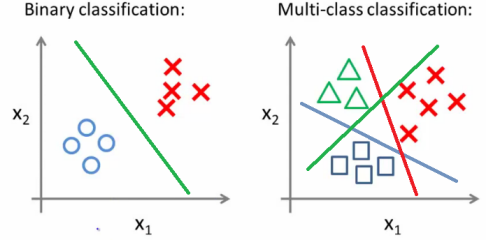
Veri setimiz çoklu sınıf yapısından oluşmaktadır. Normalde SVM çoklu sınıf içeren verilerin sınıflandırılmasında kullanılmamaktadır ancak bu sorun her sınıfın ikili ikili sınıflandırılması problemine indirgenip çözülmektedir

Modelimizi oluştururkende  scikit-learn kütüphanesi svm modülü SVC sınıfını kullandık ancak belirttiğimiz gibi doğal yapısı gereği çoklu sınıflandırmayı desteklememesi algoritmamızın yüksek başarı oranına sahip olmamasının sebebi olabilir.
 


In [29]:
model=SVC()
model.fit(train_features,y_train)
y_pred_test=model.predict(X_test)
accuracies.append(model.score(X_test, y_test)*100)
print("SVC: ",model.score(X_test, y_test)*100)

SVC:  51.5625


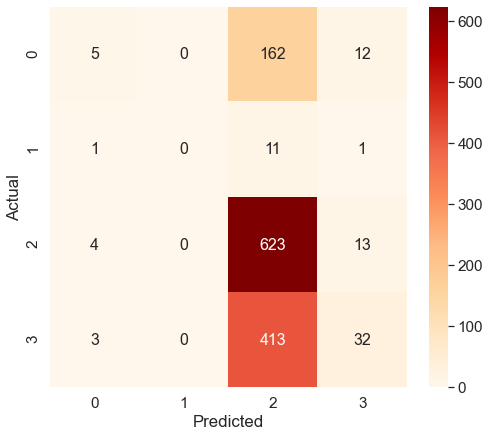

In [30]:
conf_mx = confusion_matrix(y_test, y_pred_test)
heat_cm = pd.DataFrame(conf_mx, columns=np.unique(y_test), index = np.unique(y_test))
heat_cm.index.name = 'Actual'
heat_cm.columns.name = 'Predicted'
plt.figure(figsize = (8,7))
sn.set(font_scale=1.4) # For label size
sn.heatmap(heat_cm, cmap="OrRd", annot=True, annot_kws={"size": 16},fmt='g')# font size
plt.show()

# CNN

CNN genellikle görüntü işlemede kullanılan ve girdi olarak görselleri alan bir derin öğrenme algoritmasıdır. Farklı operasyonlarla görsellerdeki featureları (özellikleri) yakalayan ve onları sınıflandıran bu algoritma farklı katmanlardan oluşmaktadır. Convolutional Layer, Pooling ve Fully Connected olan bu katmanlardan geçen görsel, farklı işlemlere tabii tutularak derin öğrenme modeline girecek kıvama gelir.Görüntü sınıflandırması için, ImageNet gibi veritabanları kullanılarak CNN mimarileri oluşturulmuş ve test edilmiştir. Bunlar içinden DenseNet ve VGG algoritmalarını projemizde kullandık.

## VGG

VGG temel seviye CNN(Evrişimli Sinir Ağı) modelidir. İsmini Oxford Üniversitesi’nde kurulan bir araştırma grubu olan Visual Geometry Group’un kısaltılmış halinden alır. Katmanlar ikili ya da üçlü şekilde kullanılır. Başarımı artırmak için evrişimli sinir ağının başarımını artırmak için daha da derinleştirilmesi tekniğine dayanır.  Giriş katmanında 224x224 görseller kullanılır, her evrişim işlemi görselden daha küçük fakat daha derin özellik haritası oluşturmayı amaçlar. Aynı zamanda görüntünün içeriğini ve stil yapısını ayrı ayrı kullanmamızı sağlar. Bu durum yapısı hakkında bize sağladığı avantajı açıkça gösterir. Modeldeki bilgiler ve CNN’deki maksimum ortaklama fonksiyonunu kullanarak sadece en yüksek değerler tutulur. Sonuca giderken de ortalama değerler kullanılır.

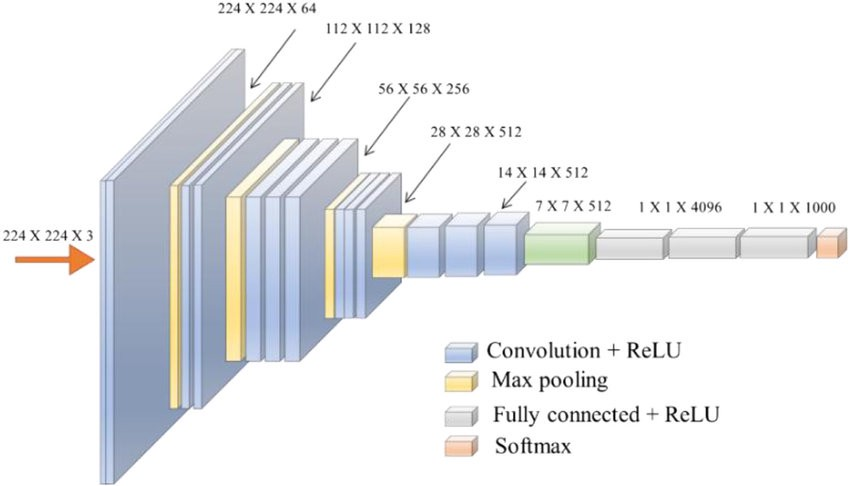


.

Aslında image işleme konusunda VGG-16 da VGG-19’da çok iyi performanslar verir. Hafıza konusu olarak ele aldığımızda VGG-16 daha fazla hafıza kullanmasına rağmen VGG-16 daha iyi bir performans verir. Projemizde bu detayları da düşünerek VGG-16’yı tercih ettik. Tensorflow ile Keras kullanarak VGG-16 modülünü projemize ekleyerek modelimizi oluşturduk.

In [17]:
base_model = VGG16(input_shape=(176,176,3), 
                   include_top=False,
                   weights="imagenet")

In [18]:
for layer in base_model.layers:
    layer.trainable=False

In [19]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 5, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)             0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 12800)             51200     
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              26216448  
_________________________________________________________________
batch_normalization_4 (Batch (None, 2048)              8192      
_________________________________________________________________
activation_2 (Activation)    (None, 2048)             

In [21]:
OPT    = tf.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[
                  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                  tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall'),
                  tf.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [22]:
VGG_model_history=model.fit(train_dataset,
                        validation_data=test_dataset,
                        epochs = 10,
                        verbose = 1)

Epoch 1/10
1281/1281 [==============================] - 120s 91ms/step - loss: 1.2344 - accuracy: 0.7656 - precision: 0.5358 - recall: 0.4661 - auc: 0.7935 - val_loss: 2.9867 - val_accuracy: 0.7660 - val_precision: 0.5323 - val_recall: 0.5278 - val_auc: 0.7701
Epoch 2/10
1281/1281 [==============================] - 113s 88ms/step - loss: 1.0185 - accuracy: 0.7910 - precision: 0.5958 - recall: 0.5099 - auc: 0.8327 - val_loss: 1.7800 - val_accuracy: 0.7561 - val_precision: 0.5122 - val_recall: 0.5090 - val_auc: 0.8068
Epoch 3/10
1281/1281 [==============================] - 115s 89ms/step - loss: 0.9154 - accuracy: 0.8104 - precision: 0.6389 - recall: 0.5559 - auc: 0.8591 - val_loss: 1.9123 - val_accuracy: 0.7807 - val_precision: 0.5643 - val_recall: 0.5387 - val_auc: 0.7996
Epoch 4/10
1281/1281 [==============================] - 116s 90ms/step - loss: 0.8767 - accuracy: 0.8184 - precision: 0.6555 - recall: 0.5766 - auc: 0.8692 - val_loss: 1.8339 - val_accuracy: 0.8020 - val_precision: 0.

In [27]:
accuracies.append(VGG_model_history.history["accuracy"][9])

## DenseNet
DenseNet'in (Yoğun Evrişimli Ağ) birçok avantajı vardır: kaybolan gradyanları hafifletir, sorunu giderir, özellik yayılmasını güçlendirir, özelliğin yeniden kullanımını teşvik eder ve parametre sayısını önemli ölçüde azaltır.

DenseNet-169'u 169 katman derinliğine sahip olmasına rağmen parametrelerde diğer modellere kıyasla nispeten düşük olduğu ve mimarinin kaybolan gradyan problemini iyi çözdüğü için seçtik.

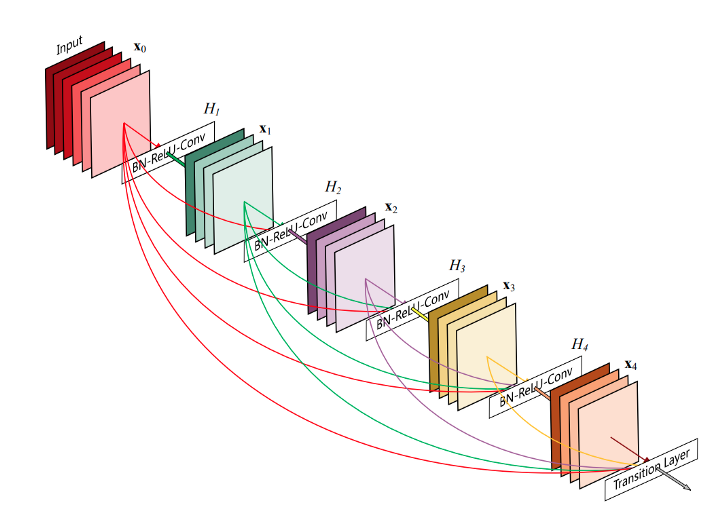

<h6><center>5 katmanlı yoğun bir blok. Her katman, önceki özellik haritalarının tümünü girdi olarak alır. </center></h6>

Bu yoğun bloklarda, her katman önceki tüm özellik haritalarını girdi olarak alır, böylece kaybolan gradyan problemini hafifleterek eğitim sürecine yardımcı olur. Şekilde de gördüğümüz bağlantılar, temelde hatanın daha da yayılmasına izin verir. Ancak gene bu bağlantılar daha fazla parametre oluşturmak yerine önceki özellik haritası bilgilerini yeniden kullandığından, özelliğin yeniden kullanımını teşvik eder ve parametre sayısını azaltır. Ve bu nedenle, toplam parametrelerdeki bu azalma nedeniyle ağın "kolektif bilgisine" erişmek ve overfitting olasılığını azaltır. DenseNet, aynı sayıda katmana sahip son teknoloji ürünü bir ResNet mimarisine kıyasla parametre sayısını yaklaşık 5 kat azaltarak çok daha iyi çalışmaktadır. Bu sebepler doğrultusunda diğer CNN algoritmaları içinden DenseNet'i projemizde tercih ettik.

In [9]:
base_model = DenseNet169(input_shape=(176,176,3), 
                         include_top=False,
                         weights="imagenet")


In [11]:
for layer in base_model.layers:
    layer.trainable=False

In [12]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 5, 5, 1664)        12642880  
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 1664)        0         
_________________________________________________________________
flatten (Flatten)            (None, 41600)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 41600)             166400    
_________________________________________________________________
dense (Dense)                (None, 2048)              85198848  
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
activation (Activation)      (None, 2048)              0

In [15]:
OPT    = tf.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[
                  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                  tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall'),
                  tf.keras.metrics.AUC(name = 'auc')
              ],
              optimizer=OPT)

In [16]:
DenseNet_model_history=model.fit(train_dataset,
                        validation_data=test_dataset,
                        epochs = 10,
                        verbose = 1)

Epoch 1/10
1281/1281 [==============================] - 227s 159ms/step - loss: 1.2362 - accuracy: 0.7625 - precision: 0.5289 - recall: 0.4571 - auc: 0.7909 - val_loss: 1.3568 - val_accuracy: 0.8002 - val_precision: 0.6058 - val_recall: 0.5754 - val_auc: 0.8395
Epoch 2/10
1281/1281 [==============================] - 203s 158ms/step - loss: 1.0009 - accuracy: 0.7970 - precision: 0.6098 - recall: 0.5224 - auc: 0.8387 - val_loss: 1.5038 - val_accuracy: 0.7709 - val_precision: 0.5427 - val_recall: 0.5317 - val_auc: 0.8105
Epoch 3/10
1281/1281 [==============================] - 199s 156ms/step - loss: 0.9107 - accuracy: 0.8077 - precision: 0.6319 - recall: 0.5528 - auc: 0.8609 - val_loss: 1.2662 - val_accuracy: 0.8112 - val_precision: 0.6247 - val_recall: 0.6130 - val_auc: 0.8624
Epoch 4/10
1281/1281 [==============================] - 188s 147ms/step - loss: 0.8289 - accuracy: 0.8285 - precision: 0.6763 - recall: 0.6026 - auc: 0.8839 - val_loss: 2.2260 - val_accuracy: 0.7768 - val_precision

In [28]:
accuracies.append(DenseNet_model_history.history["accuracy"][9])

## Değerlendirme <a class="anchor" id="evaluation"></a>

In [29]:
accuracies=[49.92,49.14,51.56,85.90,86.91]

<AxesSubplot:>

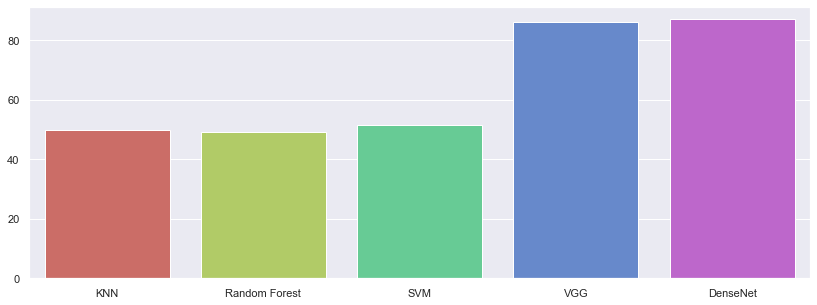

In [30]:
sn.set(rc={'figure.figsize':(14,5)})
sn.set_style('darkgrid')
sn.barplot(x=["KNN","Random Forest","SVM","VGG","DenseNet"],y=accuracies,palette = 'hls')

Projemizde tek bir makine öğrenmesi modeline bağlı kalmak yerine yaygın olarak kullanılan çeşitli algoritmalar üzerinde araştırmalar yaparak ve onların modellerini oluştururak en yüksek başarı oranını yakalamayı amaçladık. İlk deneylerimiz olan KNN, Random Forest, SVM gibi algoritmalar sonradan oluşturduğumuz CNN modellerine göre sınıflandırmada daha düşük başarı elde ettiler. Araştırmalarımız ve çıkarımlarımıza göre bu durumun birçok sebebi olduğuna karar verdik. Bu sebeplerden bazıları:
* KNN yüksek veri sayısına sahip veri setlerinde iyi bir performans göstermesine rağmen bizim veri setimiz istenildiği kadar büyük bir veri seti değildi aynı zamanda veri setinin büyüklüğünün sağlanmaması KNN algoritmasının görüntü sınıflandırmadaki performansına kötü etki etmiştir ve veri setimiz çoklu sınıftan oluşması yine KNN algoritmasının performansını kötü yönde etkilemiştir.

* Random Forest algoritması overfitting problemiyle iyi bir şekilde başa çıkmasına rağmen görüntüleri sınıflandırmada ne yazık ki başarılı bir algoritma değildir. Bunun sebebi ise görüntü işlemeyle diziye aktarılan pixel bilgilerinin Random Forest algoritması tarafından işlenirken zorlanacağı kadar fazla özellik şeklinde algılanmasıdır.

* SVM algoritması zaten doğası gereği çoklu sınıflı veriler için kullanılmaya uygun değildir. Çoklu sınıflarla çalışabilmesi için yapılan değişikliklere rağmen doğası buna uygun olmadığı için gözle görülür bir başarı elde edememiştir.


CNN algoritmaları ise bu üç algoritmaya göre gözle görülür bir biçimde daha başarılıdır. Bunun nedenleri ise :

* CNN algoritmaları görüntüleri sınıflandırmada çok başarılı algoritmalardır çünkü homojen şekilde olan çok fazla sayıdaki özelliği (görüntüler için pikselleri) ayırt etmek için tasarlanmıştır. 
* CNN algoritmaları bu tasarım avantajından faydalanıp, ayırt ettiği özellikler içinden önemli olanları insan gözetimine ihtiyaç duymadan bulabilmektedir.

Bariz şekilde daha iyi performans gösteren VGG ve DenseNet algoritmalarının sonuçlarını biraz daha detaylı inceleyelim.

Text(0.5, 1.0, 'DENSENET MODEL AUC')

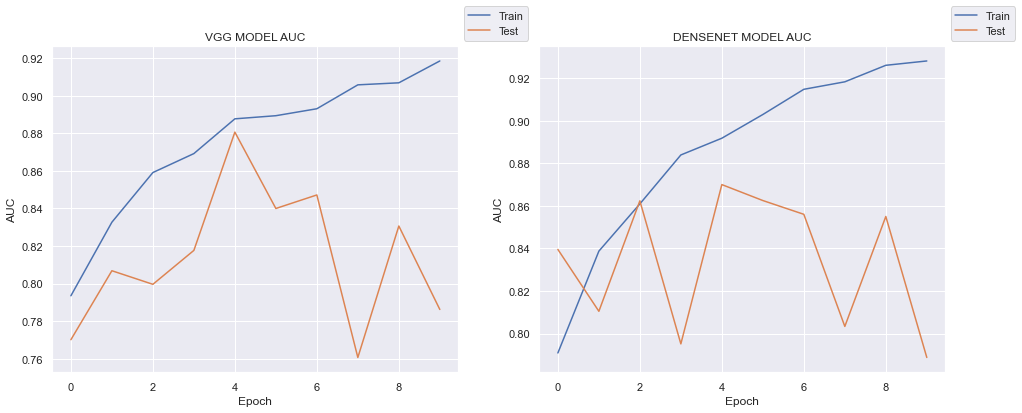

In [55]:
fig, ax=plt.subplots(1,2,figsize=(16, 6))
ax[0].set_title("VGG MODEL AUC")
ax[0].plot(VGG_model_history.history['auc'])
ax[0].plot(VGG_model_history.history['val_auc'])
ax[0].set_ylabel('AUC')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Test'], loc='lower left', bbox_to_anchor=(1,1))
ax[1].plot(DenseNet_model_history.history['auc'])
ax[1].plot(DenseNet_model_history.history['val_auc'])
ax[1].set_ylabel('AUC')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Test'], loc='lower left', bbox_to_anchor=(1,1))
ax[1].set_title("DENSENET MODEL AUC")

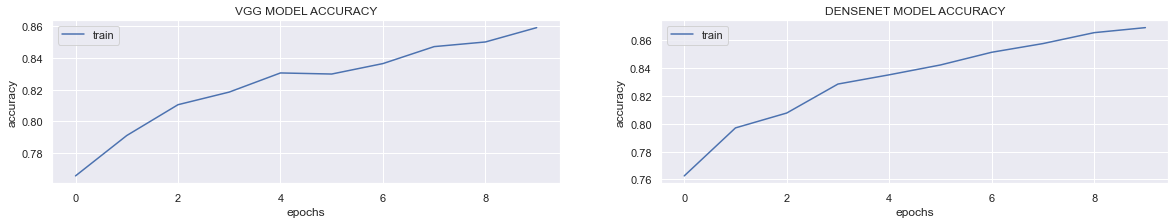

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()
for i, met in enumerate(['accuracy']):
    ax[0].plot(VGG_model_history.history[met])
    ax[0].set_title('VGG MODEL ACCURACY')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel(met)
    ax[0].legend(['train', 'test'])
    ax[1].plot(DenseNet_model_history.history[met])
    ax[1].set_title('DENSENET MODEL ACCURACY')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel(met)
    ax[1].legend(['train', 'test'])

Accuracy bir modelin başarısını ölçmek için çok kullanılan bir metriktir. Fakat genel olarak tek başına yeterli bir metrik değildir. Accuracy modelde doğru tahmin edilen değerlerin toplam veri kümesine oranı ile hesaplanır. Bunun yanında AUC ise modelde sınıfları ne kadar başarılı ayırt edebildiğini anlatır, AUC arttıkça tahmin etme başarısı artar. Sonuçlarımıza göre DenseNet algoritması da VGG algoritması da çok iyi sonuçlar vermiştir. Açıkçası, çoklu sınıf ve görüntü içerdiği için bu başarı oranlarını elde etmeleri bizi de çok etkiledi. İki algoritma arasında DenseNet daha yüksek bir accuracy ve AUC verdiği için, projemizin sonunda bu veri seti için ideal algoritmanın DenseNet olduğuna karar verdik.

## Referanslar<a class="anchor" id="references"></a>

Veri seti link: https://www.kaggle.com/tourist55/alzheimers-dataset-4-class-of-images

https://www.medicalpark.com.tr/alzheimer/hg-2172#:~:text=Alzheimer%2C%20yayg%C4%B1n%20g%C3%B6r%C3%BClen%20bir%20demans,birlikte%20yava%C5%9F%20yava%C5%9F%20ortaya%20%C3%A7%C4%B1kar.

https://www.kaggle.com/nitinsss/image-classification-with-cnn

https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/

https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/

https://www.kaggle.com/vincee/intel-image-classification-cnn-keras

https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/

https://ayyucekizrak.medium.com/deri%CC%87ne-daha-deri%CC%87ne-evri%C5%9Fimli-sinir-a%C4%9Flar%C4%B1-2813a2c8b2a9

https://medium.com/@ekrem.hatipoglu/machine-learning-classification-k-nn-k-en-yak%C4%B1n-kom%C5%9Fu-part-9-6f18cd6185d

https://www.kaggle.com/gauravrajpal/alzheimer-s-classification-vgg16-auc-87-28

https://towardsdatascience.com/review-densenet-image-classification-b6631a8ef803

https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c#:~:text=VGG16%20is%20a%20convolution%20neural,vision%20model%20architecture%20till%20date.&text=It%20follows%20this%20arrangement%20of,consistently%20throughout%20the%20whole%20architecture.

https://lib.dr.iastate.edu/cgi/viewcontent.cgi?article=1374&context=creativecomponents#:~:text=Compared%20with%20VGG16%2C%20VGG19%20is,with%20a%20max%20pooling%20layer.

https://ieeexplore.ieee.org/document/8313707